In [1]:
# import libraries
import os
import json
import requests
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
sns.set_theme(style="whitegrid")

In [2]:
# import data
df = pd.read_csv('data/tracks_1000+.csv', index_col=False)
df.drop(columns={'Unnamed: 0'}, inplace=True)

In [3]:
del df["track_id"]; del df["artist_name"]; del df["track_name"]

### This Version will be working with 1000 Samples for each Genre

In [4]:
# Make it 1000 for each category
result = df.groupby("genre").apply(lambda x: x.head(1000)).reset_index(drop=True)
result

,popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,86,blues,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.2780,123.596,232107,4
1,86,blues,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.2780,123.596,232107,4
2,86,blues,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.2780,123.596,232107,4
3,80,blues,0.636,0.676,2,-3.442,1,0.0263,0.08070,0.0000,0.0831,0.2730,113.980,208760,4
4,80,blues,0.636,0.676,2,-3.442,1,0.0263,0.08070,0.0000,0.0831,0.2730,113.980,208760,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,37,techno,0.714,0.621,9,-7.005,1,0.0893,0.20100,0.0192,0.0568,0.7450,114.237,331040,4
9996,34,techno,0.803,0.960,9,-3.342,0,0.0429,0.01570,0.0242,0.0566,0.5470,125.990,231271,4
9997,49,techno,0.880,0.477,0,-10.947,1,0.0732,0.00143,0.6270,0.0922,0.2090,125.017,539520,4
9998,47,techno,0.626,0.665,7,-10.134,0,0.0574,0.00775,0.7560,0.0811,0.0327,125.009,240000,4


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

y_tmp = pd.DataFrame(result["genre"])
X = result.drop("genre", axis=1)
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_tmp)
cols = [x.replace("x0_", "") for x in encoder.get_feature_names()]
display(len(cols))
y = pd.DataFrame(encoder.transform(y_tmp), columns=cols)
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)# , stratify=y > 0

X:\Games\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


10

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

def scaler_pipeline():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler())

def scaler_pipeline_pwr():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler(), PowerTransformer(method='yeo-johnson', standardize=True))

ct = ColumnTransformer([
        ('stdscaled', StandardScaler(), ["popularity","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms","time_signature"]),
       ], remainder='passthrough')

X_train_scaled = ct.fit_transform(X_train_org)
X_test_scaled  = ct.transform(X_test_org)
feature_names = ct.get_feature_names_out()
X_train = X_train_scaled
X_test  = X_test_scaled

In [7]:
feature_names

array(['stdscaled__popularity', 'stdscaled__danceability',
       'stdscaled__energy', 'stdscaled__key', 'stdscaled__loudness',
       'stdscaled__mode', 'stdscaled__speechiness',
       'stdscaled__acousticness', 'stdscaled__instrumentalness',
       'stdscaled__liveness', 'stdscaled__valence', 'stdscaled__tempo',
       'stdscaled__duration_ms', 'stdscaled__time_signature'],
      dtype=object)

In [8]:
y_train_rap = y_train.rap
y_train.columns

Index(['blues', 'classical', 'electronic', 'funk', 'jazz', 'metal', 'r&b',
       'rap', 'rock', 'techno'],
      dtype='object')

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [10]:
classifiers = [
    ('LogisticRegression', LogisticRegression(random_state=42)),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=42)),
    ('SVC', SVC(random_state=42))
]

result = {}
print("predicitng Rap!")
for gen in y_train.columns:
    for name, classifier in classifiers:
        y_target = y_train[gen]
        scores = [round(x,2) for x in cross_val_score(classifier, X_train, y_train[gen], cv=3, scoring='accuracy')]
        _tmp = {"min":min(scores), "max":max(scores), "mean":round(np.mean(scores),2)}
        print(f"cross_val_score: [{gen}]->{name}: {_tmp}")
        classifier.fit(X_train, y_target)
    _genre_result = {}
    for name, classifier in classifiers:
        y_pred = classifier.predict(X_test)
        _score = accuracy_score(y_test[gen], y_pred)
        print(f"test-df: [{gen}]->{name}: {round(_score, 2)}")
        _genre_result[name] = _score
    result[gen] = _genre_result

predicitng Rap!
cross_val_score: [blues]->LogisticRegression: {'min': 0.9, 'max': 0.9, 'mean': 0.9}
cross_val_score: [blues]->KNeighborsClassifier: {'min': 0.89, 'max': 0.9, 'mean': 0.89}
cross_val_score: [blues]->DecisionTreeClassifier: {'min': 0.87, 'max': 0.88, 'mean': 0.87}
cross_val_score: [blues]->RandomForestClassifier: {'min': 0.9, 'max': 0.9, 'mean': 0.9}
cross_val_score: [blues]->SVC: {'min': 0.9, 'max': 0.9, 'mean': 0.9}
test-df: [blues]->LogisticRegression: 0.89
test-df: [blues]->KNeighborsClassifier: 0.89
test-df: [blues]->DecisionTreeClassifier: 0.88
test-df: [blues]->RandomForestClassifier: 0.9
test-df: [blues]->SVC: 0.9
cross_val_score: [classical]->LogisticRegression: {'min': 0.99, 'max': 0.99, 'mean': 0.99}
cross_val_score: [classical]->KNeighborsClassifier: {'min': 0.98, 'max': 0.99, 'mean': 0.99}
cross_val_score: [classical]->DecisionTreeClassifier: {'min': 0.98, 'max': 0.98, 'mean': 0.98}
cross_val_score: [classical]->RandomForestClassifier: {'min': 0.99, 'max': 0.

In [11]:
accuracy_score

<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>

In [13]:
result

{'blues': {'LogisticRegression': 0.8945,
  'KNeighborsClassifier': 0.889,
  'DecisionTreeClassifier': 0.879,
  'RandomForestClassifier': 0.901,
  'SVC': 0.8975},
 'classical': {'LogisticRegression': 0.985,
  'KNeighborsClassifier': 0.983,
  'DecisionTreeClassifier': 0.9815,
  'RandomForestClassifier': 0.989,
  'SVC': 0.9855},
 'electronic': {'LogisticRegression': 0.902,
  'KNeighborsClassifier': 0.9075,
  'DecisionTreeClassifier': 0.8885,
  'RandomForestClassifier': 0.9195,
  'SVC': 0.908},
 'funk': {'LogisticRegression': 0.9065,
  'KNeighborsClassifier': 0.9035,
  'DecisionTreeClassifier': 0.886,
  'RandomForestClassifier': 0.911,
  'SVC': 0.9125},
 'jazz': {'LogisticRegression': 0.895,
  'KNeighborsClassifier': 0.901,
  'DecisionTreeClassifier': 0.8835,
  'RandomForestClassifier': 0.9055,
  'SVC': 0.9115},
 'metal': {'LogisticRegression': 0.9015,
  'KNeighborsClassifier': 0.903,
  'DecisionTreeClassifier': 0.9295,
  'RandomForestClassifier': 0.9365,
  'SVC': 0.907},
 'r&b': {'Logisti

In [17]:
pd.DataFrame(result).to_csv("genre-classification/data/model_performance_1k.csv")

In [26]:
#visualize diffs
performance_1k = pd.DataFrame(result)
performance_100 = pd.read_csv("genre-classification/data/model_performance_100.csv", index_col=0)
display(performance_100.head())
performance_1k.head()

,blues,classical,electronic,funk,jazz,metal,r&b,rap,rock,techno
LogisticRegression,0.886139,0.975248,0.876238,0.950495,0.896040,0.876238,0.905941,0.965347,0.925743,0.940594
KNeighborsClassifier,0.905941,0.970297,0.891089,0.930693,0.910891,0.881188,0.905941,0.925743,0.920792,0.945545
DecisionTreeClassifier,0.910891,0.975248,0.881188,0.905941,0.871287,0.920792,0.900990,0.965347,0.945545,0.930693
RandomForestClassifier,0.896040,0.980198,0.915842,0.965347,0.910891,0.945545,0.935644,0.975248,0.945545,0.945545
SVC,0.881188,0.970297,0.891089,0.940594,0.900990,0.876238,0.910891,0.955446,0.930693,0.950495


,blues,classical,electronic,funk,jazz,metal,r&b,rap,rock,techno
LogisticRegression,0.8945,0.9850,0.9020,0.9065,0.8950,0.9015,0.8945,0.9175,0.8925,0.9490
KNeighborsClassifier,0.8890,0.9830,0.9075,0.9035,0.9010,0.9030,0.8650,0.9250,0.8545,0.9490
DecisionTreeClassifier,0.8790,0.9815,0.8885,0.8860,0.8835,0.9295,0.8425,0.9410,0.8485,0.9420
RandomForestClassifier,0.9010,0.9890,0.9195,0.9110,0.9055,0.9365,0.8425,0.9425,0.8505,0.9635
SVC,0.8975,0.9855,0.9080,0.9125,0.9115,0.9070,0.8945,0.9310,0.8940,0.9565


In [28]:
performance_diff = performance_1k - performance_100
performance_diff

,blues,classical,electronic,funk,jazz,metal,r&b,rap,rock,techno
LogisticRegression,0.008361,0.009752,0.025762,-0.043995,-0.001040,0.025262,-0.011441,-0.047847,-0.033243,0.008406
KNeighborsClassifier,-0.016941,0.012703,0.016411,-0.027193,-0.009891,0.021812,-0.040941,-0.000743,-0.066292,0.003455
DecisionTreeClassifier,-0.031891,0.006252,0.007312,-0.019941,0.012213,0.008708,-0.058490,-0.024347,-0.097045,0.011307
RandomForestClassifier,0.004960,0.008802,0.003658,-0.054347,-0.005391,-0.009045,-0.093144,-0.032748,-0.095045,0.017955
SVC,0.016312,0.015203,0.016911,-0.028094,0.010510,0.030762,-0.016391,-0.024446,-0.036693,0.006005


<Figure size 640x480 with 0 Axes>

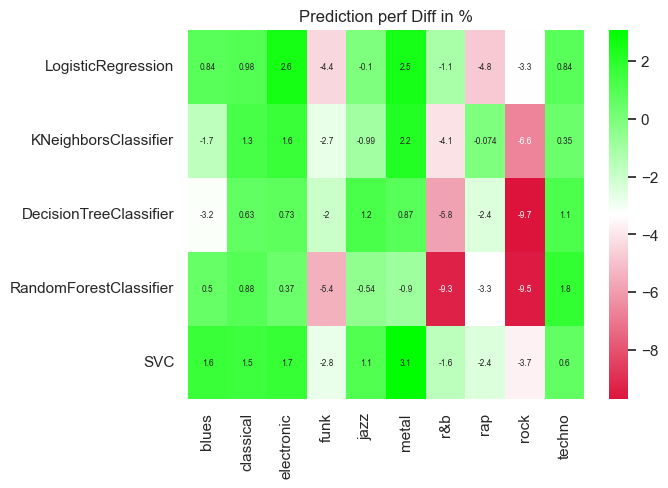

<Figure size 640x480 with 0 Axes>

In [37]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'white', 'lime'])
sns.heatmap(performance_diff * 100.0, annot=True, cmap=cmap, annot_kws={'fontsize': 6})
# Plot data on a logarithmic scale
plt.title("Prediction perf Diff in %")
plt.figure()